In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor

In [2]:
train_set = MNIST('datasets', train=True, download=True, transform=to_tensor)
len(train_set)

60000

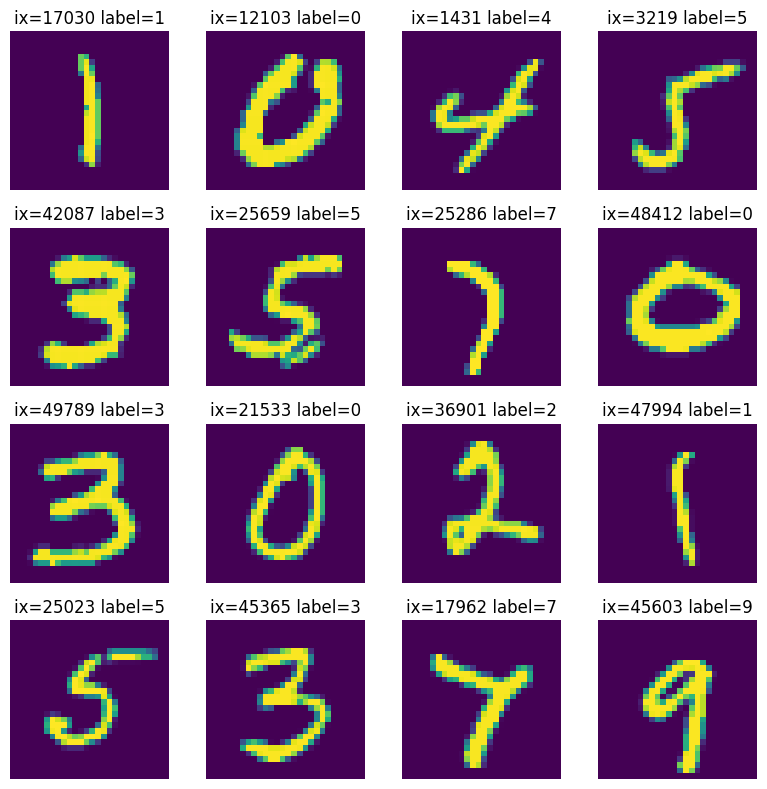

In [3]:
# See images in dataset
plt.figure(figsize=(8,8))
ixs = torch.randint(low=0, high=len(train_set), size=(16,)).tolist()
for i, ix in enumerate(ixs):
    img, label = train_set[ix]
    plt.subplot(4, 4, i+1)
    plt.imshow(torch.squeeze(img))
    plt.title(f'{ix=} {label=}')
    plt.axis('off')
plt.tight_layout()

In [4]:
class VariationalAE(nn.Module):
    def __init__(self, latent_dims: int):
        super().__init__()
        self.latent_dims = latent_dims
        self.encoder = nn.Sequential(
            # We need to generate mu and sigma so the ouput size is the double of latent_dims
            nn.Linear(in_features=28*28, out_features=2*latent_dims),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=28*28),
            nn.Sigmoid()
        )
        # nn.init.xavier_uniform_(self.decoder[-2].weight)

    def reparameterize(self, mu: Tensor, log_var: Tensor):
        std = torch.exp(0.5 * log_var)
        eps = torch.normal(mean=0, std=1.0, size=mu.shape)
        return mu + std*eps

    def latent(self, x: Tensor):
        encoding = torch.reshape(self.encoder(x), (-1, 2, self.latent_dims))
        mu, log_var = encoding[:, 0, :], encoding[:, 1, :]
        return self.reparameterize(mu, log_var)

    def forward(self, x: Tensor) -> tuple[Tensor]:
        encoding = torch.reshape(self.encoder(x), (-1, 2, self.latent_dims))
        mu, log_var = encoding[:, 0, :], encoding[:, 1, :]
        # Cant do: z = torch.normal(mean=mu, std=sigma, size=mu.shape)
        # because than our forward pass would not be differentiable
        z = self.reparameterize(mu, log_var)
        return (self.decoder(z), mu, log_var)

net = VariationalAE(latent_dims=64)
net

VariationalAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

In [5]:
def loss_function(x: Tensor, x_hat: Tensor, mu: Tensor, log_var: Tensor):
    recons_loss = nn.functional.mse_loss(x_hat, x)
    KLd_loss = torch.mean(0.5 * torch.sum(mu**2 + log_var.exp() - 1 - log_var, dim=1))
    return recons_loss + 0.00025*KLd_loss

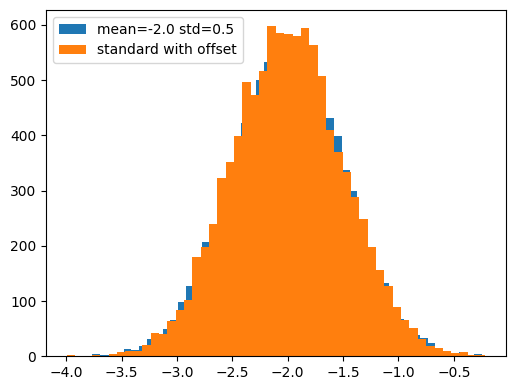

In [6]:
plt.figure(figsize=(10,4))

# Normal distribution with mean=-2.0 and std=0.5
plt.subplot(1, 2, 2)
plt.hist(torch.normal(mean=-2, std=0.5, size=(10000,)), bins=50, label='mean=-2.0 std=0.5')

# Standard normal distribution with offset
plt.hist(-2.0 - 0.5*torch.randn(size=(10000,)), bins=50, label='standard with offset')

plt.legend()
plt.tight_layout()

In [7]:
# Train the network
epochs = 20
train_loader = DataLoader(train_set, batch_size=256)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(1, epochs+1):
    running_loss = 0
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()

        x = torch.flatten(images, start_dim=1)
        x_hat, mu, log_var = net(x)
        loss = loss_function(x, x_hat, mu, log_var)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
    
    print(f'Epoch {epoch} completed! Avg loss: {running_loss/len(train_loader)}')

Epoch 1 completed! Avg loss: 0.08270340802821707
Epoch 2 completed! Avg loss: 0.04919276357965267
Epoch 3 completed! Avg loss: 0.040671087468558166
Epoch 4 completed! Avg loss: 0.035961536666814314
Epoch 5 completed! Avg loss: 0.03283018679060835
Epoch 6 completed! Avg loss: 0.030707245581644647
Epoch 7 completed! Avg loss: 0.029285810887813568
Epoch 8 completed! Avg loss: 0.028251919499103058
Epoch 9 completed! Avg loss: 0.027456636124468865
Epoch 10 completed! Avg loss: 0.026863389858540067
Epoch 11 completed! Avg loss: 0.0264140341193118
Epoch 12 completed! Avg loss: 0.026006276453746126
Epoch 13 completed! Avg loss: 0.025686670602002044
Epoch 14 completed! Avg loss: 0.025416147082727006
Epoch 15 completed! Avg loss: 0.025202977102487645
Epoch 16 completed! Avg loss: 0.025010518040111725
Epoch 17 completed! Avg loss: 0.024847888716674867
Epoch 18 completed! Avg loss: 0.024697177928495913
Epoch 19 completed! Avg loss: 0.024579075018459177
Epoch 20 completed! Avg loss: 0.0244643532849

In [8]:
images = torch.cat([img for img, _ in train_set])
labels = torch.tensor([label for _, label in train_set])
images.shape, labels.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [9]:
net.eval()
with torch.no_grad():
    x = images.flatten(start_dim=1)
    latent_vecs = net.latent(x)
latent_vecs.shape

torch.Size([60000, 64])

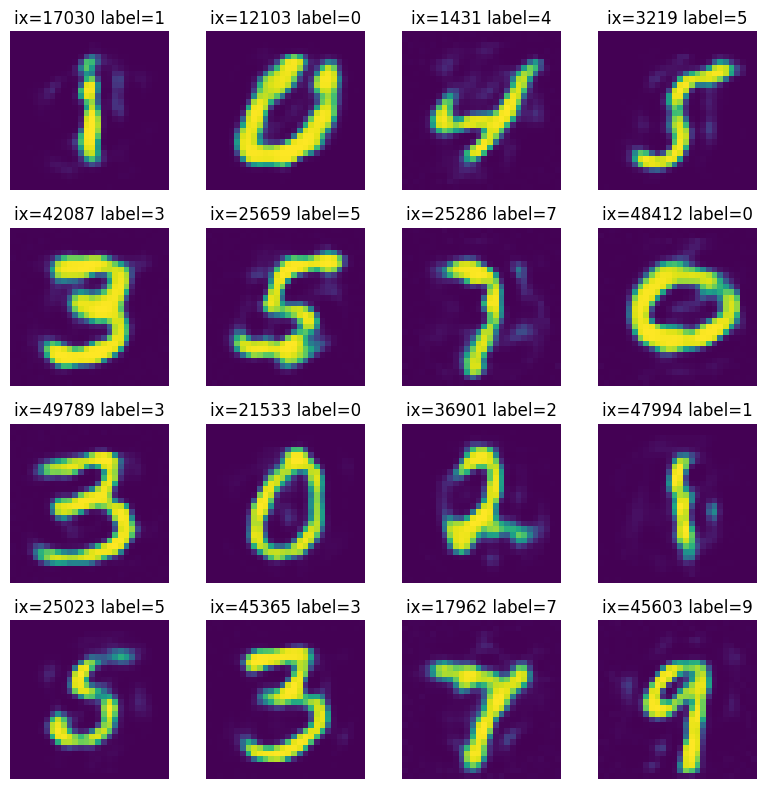

In [14]:
# See images from encoder
plt.figure(figsize=(8,8))
for i, ix in enumerate(ixs):
    with torch.no_grad():
        output = net.decoder(latent_vecs[ix])
    img = torch.reshape(output, (28, 28))
    label = labels[ix].item()

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(f'{ix=} {label=}')
    plt.axis('off')
plt.tight_layout()

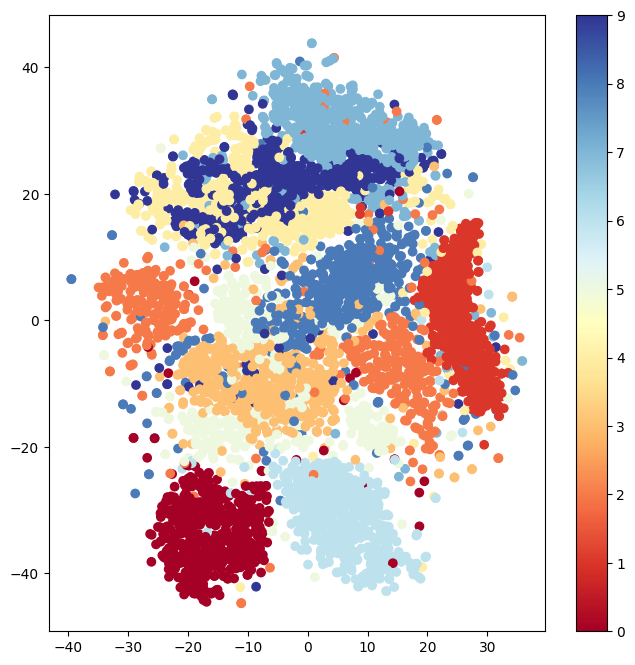

In [11]:
from matplotlib import colormaps
from sklearn.manifold import TSNE

tsne_indexes = torch.randint(low=0, high=len(train_set), size=(5000,))

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=100)
latent_tsne = tsne.fit_transform(latent_vecs[tsne_indexes])

cm = colormaps['RdYlBu']
plt.figure(figsize=(8,8))
sc = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels[tsne_indexes], cmap=cm)
plt.colorbar(sc)
plt.show()